In [1]:
from fastbook import *
from fastai.vision.widgets import *

Using the Bing search Api from Azure with the corresponding key

In [2]:
key = os.environ.get("AZURE_SEARCH_KEY", "api-key")

Overriding the search_image_key function from the fastai library (the original has a wrong search url) 

In [4]:
def search_images_bing(key, term, max_images: int = 150, **kwargs):    
     params = {'q':term, 'count':max_images}
     headers = {"Ocp-Apim-Subscription-Key":key}
     search_url = "https://api.bing.microsoft.com/v7.0/images/search"
     response = requests.get(search_url, headers=headers, params=params)
     response.raise_for_status()
     search_results = response.json()    
     return L(search_results['value'])

In [5]:
flower_types = "tulip", "rose", "orchids"
path = Path("flowers")

Creating the main folder "flowers" and subfolders according to the name of the flowers. Then, downloading the images to the respective folders

In [10]:
if not path.exists():
    path.mkdir()
    for f in flower_types:
        dest = (path/f)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f"flower {f}")
        download_images(dest, urls=results.attrgot("contentUrl"))

In [11]:
fns = get_image_files(path)
fns

(#447) [Path('flowers/tulip/00000006.jpg'),Path('flowers/tulip/00000002.jpg'),Path('flowers/tulip/00000004.jpg'),Path('flowers/tulip/00000000.jpg'),Path('flowers/tulip/00000005.jpg'),Path('flowers/tulip/00000003.jpg'),Path('flowers/tulip/00000009.jpg'),Path('flowers/tulip/00000011.jpg'),Path('flowers/tulip/00000008.jpg'),Path('flowers/tulip/00000007.jpg')...]

In [12]:
failed = verify_images(fns)
failed

(#3) [Path('flowers/tulip/00000090.jpg'),Path('flowers/tulip/00000095.jpg'),Path('flowers/rose/00000074.jpg')]

Deleting the images that fail to download

In [13]:
failed.map(Path.unlink)

(#3) [None,None,None]

Creating a DataBlock object. This contains the independent (ImageBlock=the images for clasification) and dependent variables (CategoryBlock=we want to classify into categories).
Next, we specify the function to obtain the images, how to split the set into training and validation sets and how to label the images(folder name).
Finally, we transform each object with the RandomResizedCrop class, so every image has the same size by cropping the file, but using different parts of the image so important details are not lost. Addittionally, we use data auggmetation (aug_transforms) to create random variations on the pictures (angle, shadows, etc)

In [14]:
flowers = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

We load our dataset passing the path of the main folder

In [15]:
dls = flowers.dataloaders(path)

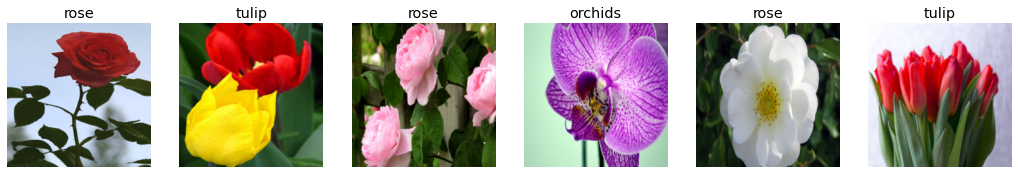

In [16]:
dls.valid.show_batch(max_n=6, nrows=1)

Training the model with a NN of 18 layers and using the accuracy metric.
We are using a pre-trained model, so we need to fine-tune it with an initial epoch so the NN adapts to our needs.
Then we train the model for 4 epochs

In [17]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,1.509012,0.486991,0.818182,00:09


epoch,train_loss,valid_loss,accuracy,time
0,0.432535,0.222287,0.954545,00:11
1,0.341905,0.153883,0.954545,00:10
2,0.265478,0.155358,0.965909,00:10
3,0.227717,0.156766,0.965909,00:10


Plotting a confussion matrix to visualice the performance of the model

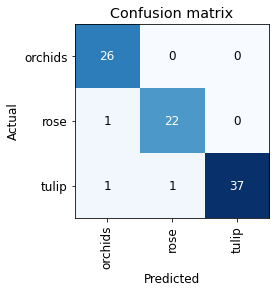

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Requesting the predictions with more loss (wrong prediction, right prediction but with low confidence)

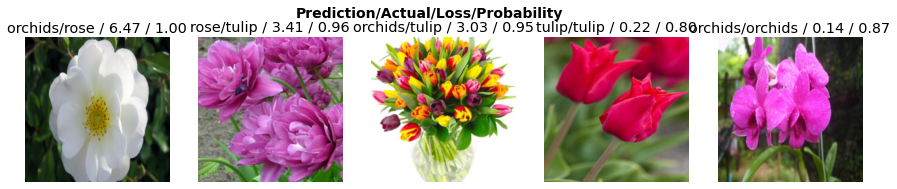

In [19]:
interp.plot_top_losses(5, nrows=1)

In [21]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [22]:
for idx in cleaner.delete(): 
    cleaner.fns[idx].unlink()

Testing the model with images that we can upload

In [23]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

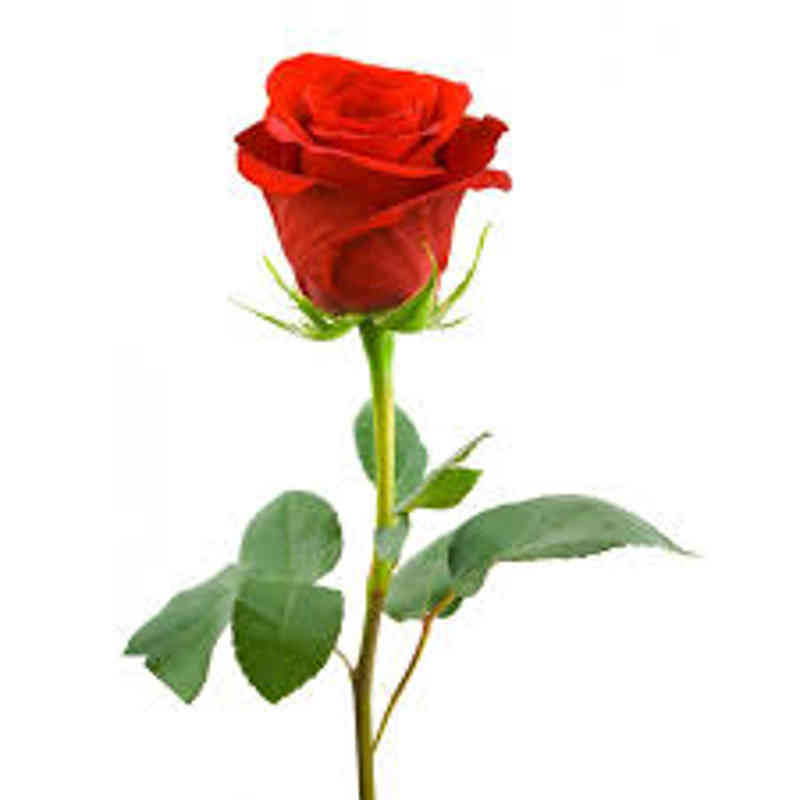

In [31]:
img = PILImage.create(btn_upload.data[-1])
img

In [32]:
pred,pred_idx,probs = learn.predict(img)

In [33]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: rose; Probability: 0.9999')